In [1]:
# imports

from functools import reduce
import itertools
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from barnacle import plot_factors_heatmap
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import tensorly as tl
from tensorly.cp_tensor import CPTensor
import tlviz
from tlviz.factor_tools import factor_match_score
from tlab.cp_tensor import load_cp_tensor
import xarray as xr
from barnacle.tensors import SparseCPTensor

# ignore chained assignment warning in pandas
pd.set_option('mode.chained_assignment', None)


In [2]:
# helpful functions
    
# function to select subset of indices in cp tensor
def subset_cp_tensor(cp_tensor, subset_indices):
    '''Selects subset of cp_tensor based on provided indices
    
    Parameters
    ----------
    cp_tensor : tensorly.CPTensor
        CPTensor object with (weights, factors).
    subset_indices : dict(int: index-like)
        Dictionary with mode as key and value an integer index of 
        the positions to be downselected from `cp_tensor`.
        Example: {1: [0, 1, 3, 4, 5, 8]}
        
    Returns
    -------
    subset_cp : tensorly.CPTensor
        Subset CPTensor.
    '''
    weights, factors = cp_tensor
    new_factors = factors.copy()
    for mode, index in subset_indices.items():
        new_factors[mode] = factors[mode][index]
    return(CPTensor((weights, new_factors)))


# functions to build continuous colormap
# source: https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


In [17]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

div_hexes = ['#7222D3', neutral_color, '#FF780A']
div_cmap = get_continuous_cmap(div_hexes)


# collect and organize data

In [10]:
# data structures

# parameters
bootstraps = np.arange(5)
replicates = ['A', 'B', 'C']
datapath = Path('../models/')
outdir = Path('../figures/v2-batch-t=0.01/r=50-l=10/')

ranks = {
    'pro': {
        'ref': 50, 
        'comp': [1, 10, 15, 20, 30, 40, 50]
    }, 
    'syn': {
        'ref': 50, 
        'comp': [1, 10, 15, 20, 30, 40, 50]
    }
}
lambdas = {
    'pro': 10., 
    'syn': 10.
}

# set up data structure to store sample name data
samplenames = {
    'pro' : {
        rep: [] for rep in replicates
    },
    'syn' : {
        rep: [] for rep in replicates
    }
}

# set up data structures to store cp tensors
cps = {
    'pro' : {
        rep: {} for rep in replicates
    },
    'syn' : {
        rep: {} for rep in replicates
    }
}
aligned_cps = {
    'pro' : {
        rep: {} for rep in replicates
    },
    'syn' : {
        rep: {} for rep in replicates
    }
}


In [11]:
# fetch samplename labels for each shuffled replicate set

# collect sample names of each bootstrap/replicate pair
for cyano in ['pro', 'syn']: 
    for rep in replicates:
        for boot in bootstraps:
            filepath = datapath / '{}/bootstrap{}/replicate{}/shuffled_replicate_{}.nc'.format(
                cyano, boot, rep, rep
            )
            ds = xr.open_dataset(filepath)
            samplenames[cyano][rep].append(ds.samplename.data)

    # compile set of samplenames common to all bootstrap / replicate splits
    samplenames[cyano]['common'] = reduce(
        np.intersect1d, 
        itertools.chain.from_iterable([samplenames[cyano][r] for r in replicates])
    )

# import one shuffled tensor dataset for reference
pro_ds = xr.open_dataset(datapath / 'pro/bootstrap{}/dataset_bootstrap_{}.nc'.format(bootstraps[0], bootstraps[0]))
syn_ds = xr.open_dataset(datapath / 'syn/bootstrap{}/dataset_bootstrap_{}.nc'.format(bootstraps[0], bootstraps[0]))

syn_ds


<xarray.Dataset>
Dimensions:     (ortholog: 6161, clade: 6, sample: 222)
Coordinates:
  * ortholog    (ortholog) int64 60000001 60000002 ... 60040219 60040245
  * clade       (clade) object '5.1A-I' '5.1A-II' ... '5.1B-VII' 'CDR2'
  * sample      (sample) object 'G1.SURF.NS.S02C1.15m.A' ... 'G3.UW.NS.UW40_2...
Data variables:
    readcount   (ortholog, clade, sample) float64 ...
    residual    (ortholog, clade, sample) float64 ...
    replicate   (sample) object ...
    samplename  (sample) object ...
    annotation  (ortholog) object ...
Attributes:
    shuffle_seed:  1336149668

In [12]:
# import all fitted models, and subset them to just the common samplenames

for cyano in ['pro', 'syn']:
    for rep in replicates:
        for rank in ranks[cyano]['comp']:
            # initialize list of cp tensors for each rank
            cps[cyano][rep][rank] = []
            aligned_cps[cyano][rep][rank] = []
            for boot in bootstraps:
                # put together data path
                path_cp = '{}/bootstrap{}/replicate{}/rank{}/lambda{}/fitted_model.h5'.format(
                    cyano, boot, rep, rank, lambdas[cyano]
                )
                # store normalized cp tensor to cps
                cp = tl.cp_normalize(load_cp_tensor(datapath / path_cp))
                cps[cyano][rep][rank].append(cp)
                # pull out common samplenames and store in aligned_cps
                idx = np.where(np.isin(samplenames[cyano][rep][boot], samplenames[cyano]['common']))[0]
                aligned_cps[cyano][rep][rank].append(
                    subset_cp_tensor(cp, {2: idx})
                )
            
aligned_cps['syn']['A'][10][0]


(weights, factors) : rank-10 CPTensor of shape (6161, 6, 55)

# compare aligned components
- choose best representative reference cp tensor
    - reference rank
    - choose based on best overall mean FMS agains all other cp tensors
- sort reference tensor components in order of variance explained
- align all other tensors to sorted reference tensor (using None-type tensors to fill gaps)
- calculate FMS between each pair of aligned components (comparison vs. reference)


In [13]:
# find best representative reference cp tensor for each genus

results = []
for cyano, ref_rep, ref_boot in list(itertools.product(['pro', 'syn'], replicates, bootstraps)):
    ref_rank = ranks[cyano]['ref']
    reference_cp = aligned_cps[cyano][ref_rep][ref_rank][ref_boot]
    for comp_rep, comp_rank, comp_boot in list(itertools.product(replicates, ranks[cyano]['comp'], bootstraps)):
        # no point in comparing to self
        if ref_rep == comp_rep and ref_rank == comp_rank and ref_boot == comp_boot:
            continue
        comparison_cp = aligned_cps[cyano][comp_rep][comp_rank][comp_boot]
        fms = factor_match_score(
            reference_cp, 
            comparison_cp, 
            consider_weights=False
        )
        results.append({
            'genus': cyano, 
            'reference_rank': ref_rank, 
            'reference_bootstrap': ref_boot, 
            'reference_replicate': ref_rep, 
            'comparison_rank': comp_rank, 
            'comparison_bootstrap': comp_boot, 
            'comparison_replicate': comp_rep, 
            'fms': fms, 
        })
        
fms_df = pd.DataFrame(results)

# summarize overall mean fms
best_rep_df = fms_df.groupby([
    'genus', 
#     'comparison_rank', 
    'reference_rank', 
    'reference_bootstrap', 
    'reference_replicate'
]).agg(
    mean_fms=('fms', 'mean'), 
    boot_count=('fms', 'count')
).reset_index()
# find the top mean for each comparison rank
# best_rep_df = best_rep_df.sort_values(['genus', 'mean_fms'], ascending=False)
best_rep_df = best_rep_df.iloc[best_rep_df.groupby([
    'genus', 
#     'comparison_rank'
]).mean_fms.idxmax().values, :]

best_rep_df


,genus,reference_rank,reference_bootstrap,reference_replicate,mean_fms,boot_count
8,pro,50,2,C,0.629146,104
24,syn,50,3,A,0.635643,104


In [14]:
# collect aligned component comparison data

results = []
for cyano in ['pro', 'syn']:
    # pull out reference cp
    specs = best_rep_df[best_rep_df['genus'] == cyano].to_dict('records')[0]
    ref_rep = specs['reference_replicate']
    ref_rank = specs['reference_rank']
    ref_boot = specs['reference_bootstrap']
    # sort reference cp factors in order of explained variance
    reference_cp = tlviz.factor_tools.permute_cp_tensor(
        aligned_cps[cyano][ref_rep][ref_rank][ref_boot], 
        consider_weights=True
    ) 
    aligned_cps[cyano][ref_rep][ref_rank][ref_boot] = reference_cp
    # separate out components
    ref_components = SparseCPTensor(reference_cp).get_components()
    # iterate through all cp tensors to be compared
    for comp_rep, comp_rank, comp_boot in list(itertools.product(replicates, ranks[cyano]['comp'], bootstraps)):
        # no point in comparing to self
        if ref_rep == comp_rep and ref_rank == comp_rank and ref_boot == comp_boot:
            continue
        # re-align comparison cp to the reference cp
        comparison_cp = tlviz.factor_tools.permute_cp_tensor(
            aligned_cps[cyano][comp_rep][comp_rank][comp_boot], 
            reference_cp_tensor=reference_cp, 
            consider_weights=False, 
            allow_smaller_rank=True
        )
        aligned_cps[cyano][comp_rep][comp_rank][comp_boot] = comparison_cp
        # compare each aligned component
        for i, comp_component in enumerate(SparseCPTensor(comparison_cp).get_components()):
            # skip the None-type components included for aligning smaller cp tensors
            if np.all(np.isnan(comp_component.factors[0])):
                continue
            # compare components
            fms = factor_match_score(
                comp_component, 
                ref_components[i], 
                consider_weights=False,
            )
            # save results
            results.append({
                'genus': cyano, 
                'reference_bootstrap': ref_boot, 
                'reference_replicate': ref_rep, 
                'reference_rank': ref_rank, 
                'reference_component': i, 
                'comparison_bootstrap': comp_boot, 
                'comparison_replicate': comp_rep, 
                'comparison_rank': comp_rank, 
                'comparison_component': i, 
                'fms': fms 
            })
            
component_df = pd.DataFrame(results)
component_df


,genus,reference_bootstrap,reference_replicate,reference_rank,reference_component,comparison_bootstrap,comparison_replicate,comparison_rank,comparison_component,fms
0,pro,2,C,50,5,0,A,1,5,0.519064
1,pro,2,C,50,1,1,A,1,1,0.619526
2,pro,2,C,50,29,2,A,1,29,0.584390
3,pro,2,C,50,29,3,A,1,29,0.622926
4,pro,2,C,50,29,4,A,1,29,0.556090
...,...,...,...,...,...,...,...,...,...,...
4875,syn,3,A,50,45,4,C,50,45,0.001282
4876,syn,3,A,50,46,4,C,50,46,0.089997
4877,syn,3,A,50,47,4,C,50,47,0.033112
4878,syn,3,A,50,48,4,C,50,48,0.000000


In [15]:
# calculate variation explained by the best representative cp tensor for each bootstrapped dataset

results = []
for cyano in ['pro', 'syn']:
    # pull out best representative cp tensor
    specs = best_rep_df[best_rep_df['genus'] == cyano].to_dict('records')[0]
    ref_rep = specs['reference_replicate']
    ref_rank = specs['reference_rank']
    ref_boot = specs['reference_bootstrap']
    # get reference cp (down-selected to just common samples)
    reference_cp = aligned_cps[cyano][ref_rep][ref_rank][ref_boot]
    # separate out components
    ref_components = SparseCPTensor(reference_cp).get_components()
    # iterate through all cp tensors to be compared
    for comp_rep, comp_boot in list(itertools.product(replicates, bootstraps)):
        # no point in comparing to self
        if ref_rep == comp_rep and ref_boot == comp_boot:
            continue
        # get shuffled tensor data for each bootstrap
        filepath = '{}/bootstrap{}/replicate{}/shuffled_replicate_{}.nc'.format(
            cyano, comp_boot, comp_rep, comp_rep
        )
        reference_ds = xr.open_dataset(datapath / filepath)
        # pull out just the data corresponding to common sample indices
        reference_tensor = reference_ds.sel(samplename=samplenames[cyano]['common']).residual.data
        # calculate variance captured by each factor
        explained_vars = tlviz.factor_tools.percentage_variation(
            reference_cp, 
            dataset=reference_tensor, 
            method='data'
        )
        # calculate fit of each component
        for i, component in enumerate(ref_components):
            fit = tlviz.model_evaluation.fit(component, reference_tensor)
            # save results
            results.append({
                'genus': cyano, 
                'reference_bootstrap': ref_boot, 
                'reference_replicate': ref_rep, 
                'reference_rank': ref_rank, 
                'comparison_bootstrap': comp_boot, 
                'comparison_replicate': comp_rep, 
                'comparison_component': i, 
                'explained_variation': explained_vars[i], 
                'component_fit': fit 
            })

var_df = pd.DataFrame(results)
var_df


,genus,reference_bootstrap,reference_replicate,reference_rank,comparison_bootstrap,comparison_replicate,comparison_component,explained_variation,component_fit
0,pro,2,C,50,0,A,0,2.219475,0.004620
1,pro,2,C,50,0,A,1,1.833161,-0.008678
2,pro,2,C,50,0,A,2,1.568435,0.026462
3,pro,2,C,50,0,A,3,1.464881,-0.018026
4,pro,2,C,50,0,A,4,1.282889,0.016950
...,...,...,...,...,...,...,...,...,...
1395,syn,3,A,50,4,C,45,0.027872,0.001112
1396,syn,3,A,50,4,C,46,0.013194,0.000306
1397,syn,3,A,50,4,C,47,0.004881,0.000124
1398,syn,3,A,50,4,C,48,0.000000,0.000000


# plot component robustness

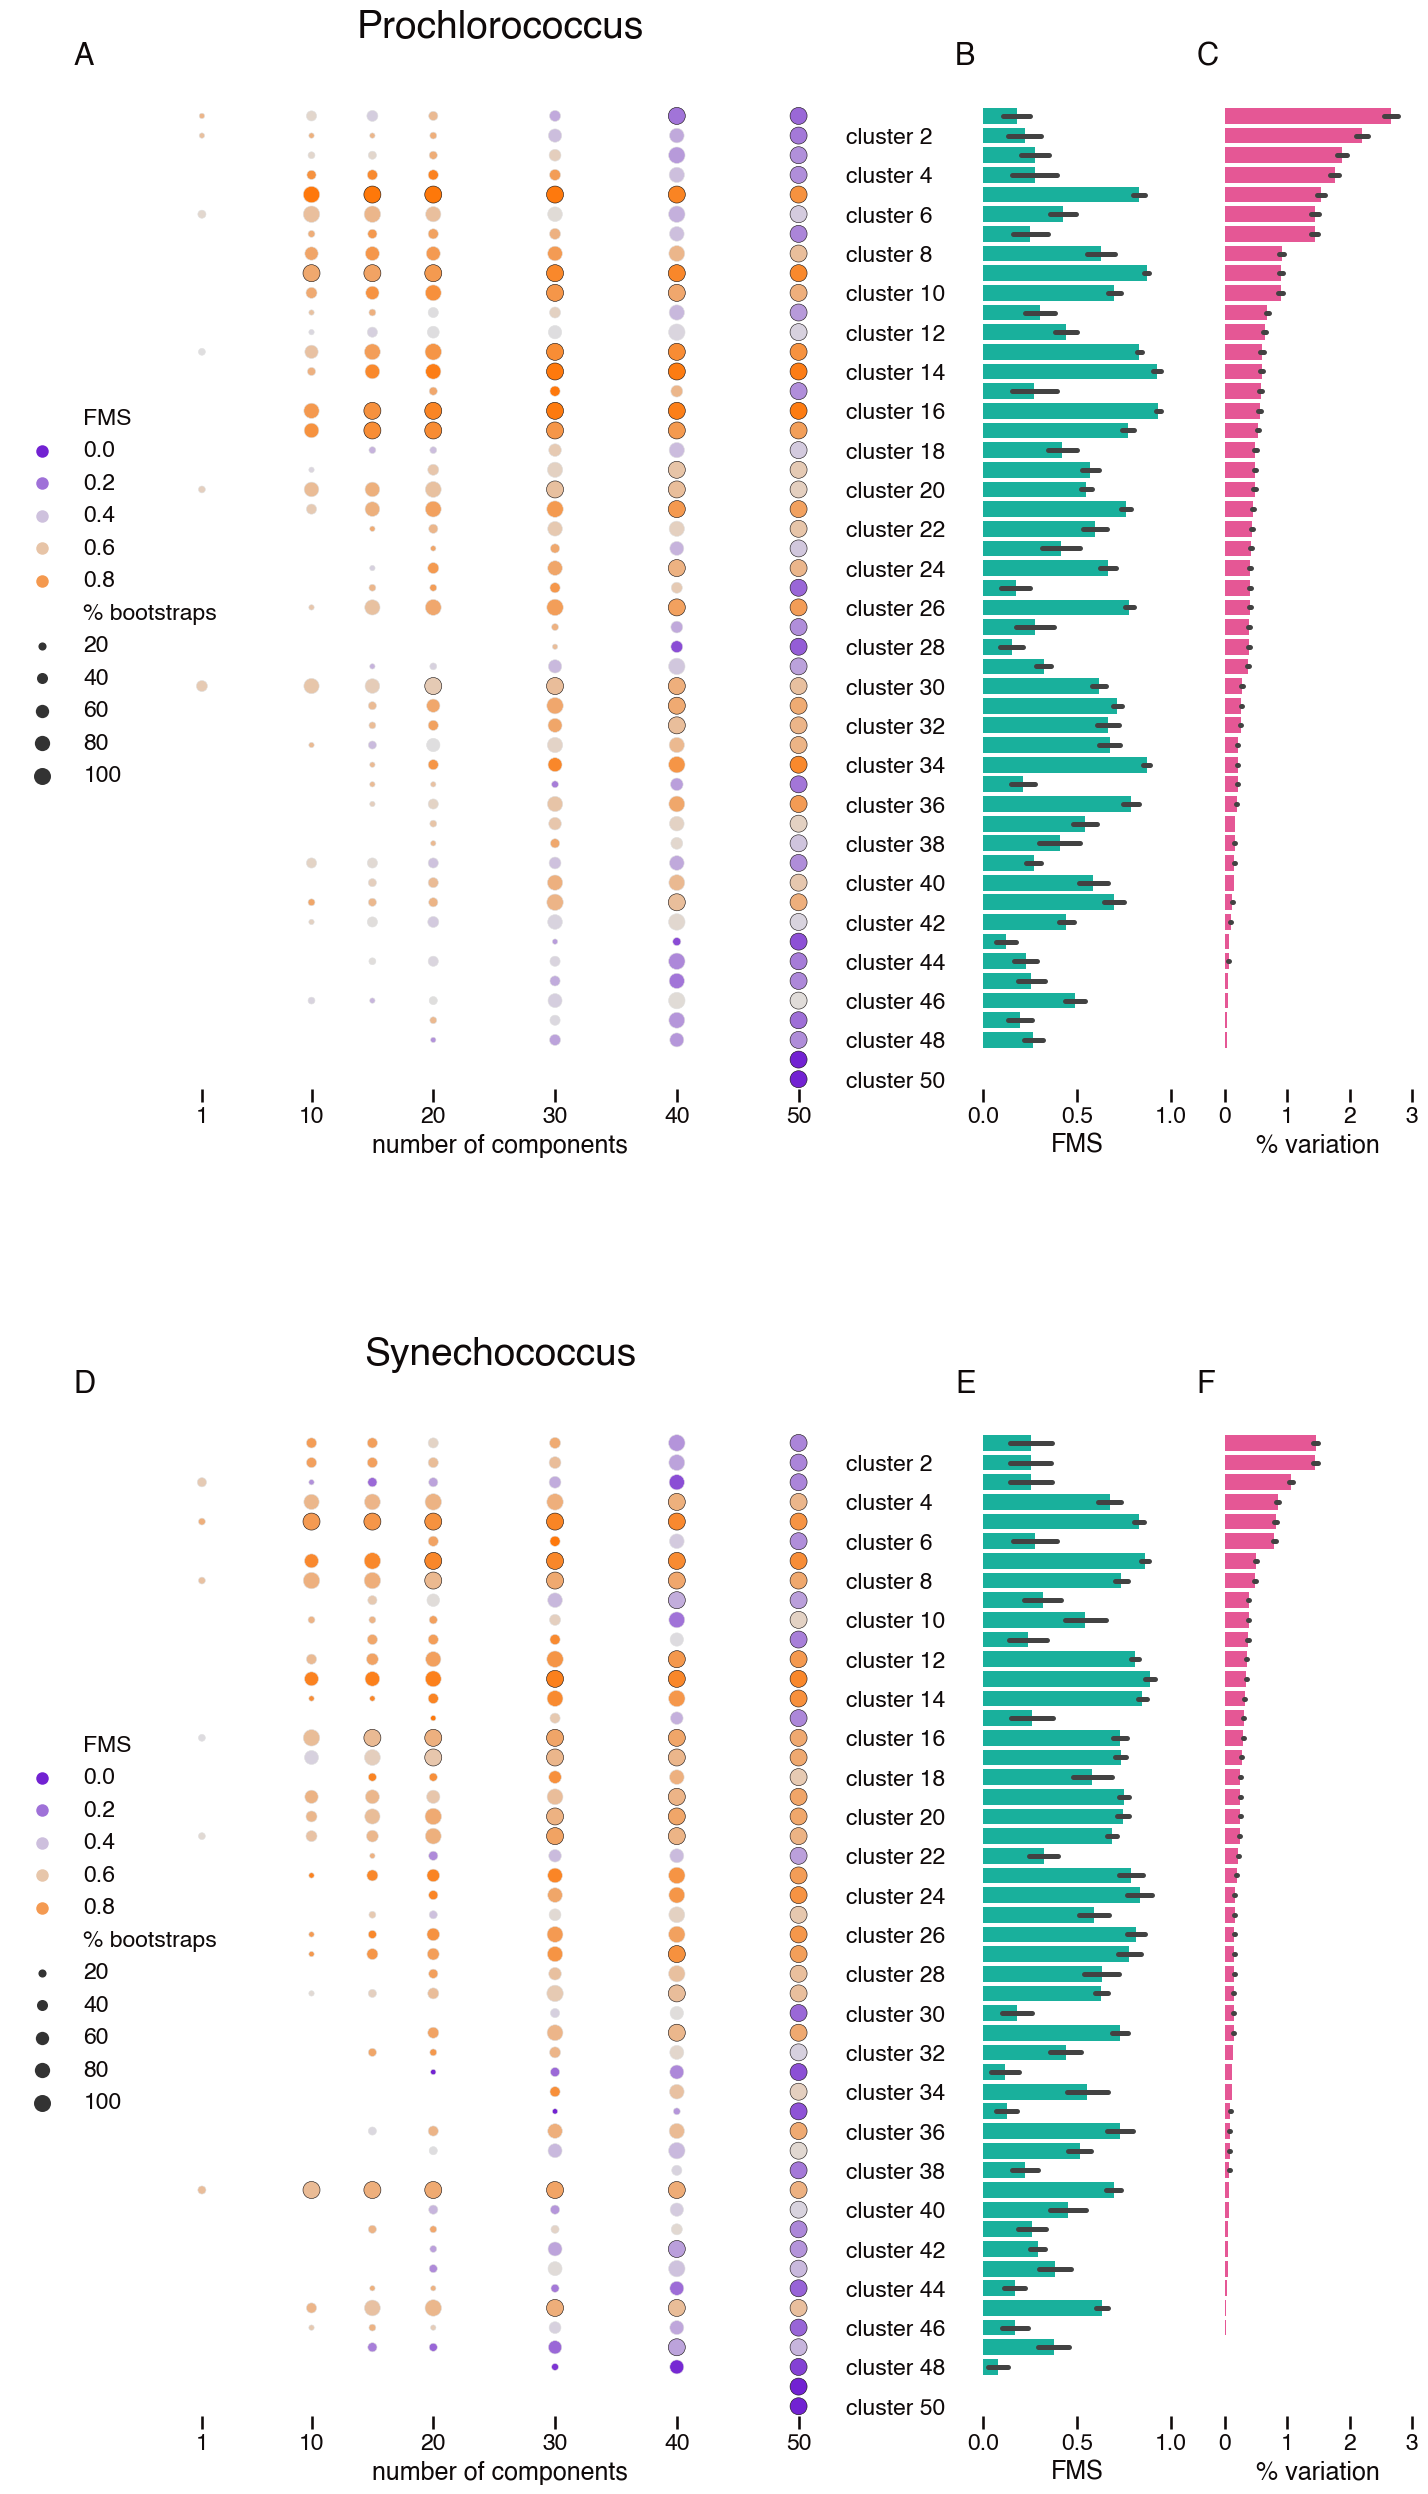

In [19]:
# component robustness plot

# make multiple plots sub
fig, axes = plt.subplots(
    2, 4, figsize=(16, 30), sharey=True, width_ratios=(7, .5, 2, 2), gridspec_kw={'hspace': 0.35}
)
annotations = {0: 'A', 2: 'B', 3: 'C', 4: 'D', 6: 'E', 7: 'F'}
annot_kws = dict(
    xy=(-0.15, 1.05), xycoords='axes fraction', va='center', ha='left', 
    weight='bold', fontsize=22, annotation_clip=False
)

for row, cyano in enumerate(['pro', 'syn']):

    # set up component robustness dataframe
    df = component_df[component_df['genus'] == cyano]
    df = df.groupby(['comparison_rank', 'reference_component']).agg(
        FMS = ('fms', 'mean'), 
        bootstrap_count = ('fms', 'count')
    ).reset_index()
    # calculate bootstrap percentage
    n_bootstraps = len(bootstraps) * 3
    df['total_bootstraps'] = n_bootstraps
    df.loc[df['comparison_rank'] == ranks[cyano]['ref'], 'total_bootstraps'] = n_bootstraps - 1
    df['% bootstraps'] = df['bootstrap_count'] / df['total_bootstraps'] * 100
    df['all bootstraps'] = df['% bootstraps'] == 100

    # set up component dataframe
    comp_stats_df = component_df[
        (component_df['genus'] == cyano) & 
        (component_df['comparison_rank'] == ranks[cyano]['ref'])
    ]

    # plot robustness patterns
    i = 0
    axes[row][i].annotate(annotations[row*4+i], **annot_kws)
    axes[row][i].annotate(
        {0: 'Prochlorococcus', 1: 'Synechococcus'}[row], xy=(0.5, 1.08), xycoords='axes fraction', 
        va='center', ha='center', weight='bold', style='italic', fontsize=28, annotation_clip=False
    )
    marker_palette = {True: line_color, False: neutral_color}
    sns.scatterplot(
        x='comparison_rank', 
        y='reference_component', 
        hue='FMS', 
        size='% bootstraps', 
        sizes=(15, 150), 
        edgecolor=df['all bootstraps'].map(marker_palette), 
        palette=div_cmap, 
        data=df, 
        legend='brief',
        ax=axes[row][i]
    ); 
    axes[row][i].set(xlabel='number of components', xticks=[1, 10, 20, 30, 40, 50], ylabel=None)
    axes[row][i].legend(loc='center right', alignment='right', bbox_to_anchor=(0.1, 0.5));

    # skip axis for label space
    i = 1
    axes[row][i].tick_params(left=False, bottom=False, labelbottom=False)

    # plot component fms
    i = 2
    axes[row][i].annotate(annotations[row*4+i], **annot_kws)
    sns.barplot(
        data=comp_stats_df, 
        x='fms', 
        y='comparison_component', 
        errorbar='se', 
        orient='h', 
        color=sns.color_palette()[2], 
        ax=axes[row][i]
    ); 
    axes[row][i].set(xlabel='FMS', xticks=[0, .5, 1], ylabel=None);
    axes[row][i].tick_params(left=False)

    # plot % variance explained
    i = 3
    axes[row][i].annotate(annotations[row*4+i], **annot_kws)
    sns.barplot(
        data=var_df[var_df['genus'] == cyano], 
        x='explained_variation', 
        y='comparison_component', 
        errorbar='se', 
        orient='h', 
        color=sns.color_palette()[3], 
        ax=axes[row][i]
    ); 
    axes[row][i].set(xlabel='% variation', xticks=[0, 1.0, 2.0, 3.0], ylabel=None)
    axes[row][i].tick_params(left=False)

    # set cluster labels
    axes[row][0].tick_params(left=False, right=False, labelleft=False, labelright=True)
    axes[row][0].set_yticks(np.arange(1, 51, 2), [f'cluster {i+1}' for i in np.arange(1, 51, 2)]);

plt.savefig(outdir / 'component-robustness.png', bbox_inches='tight')


# List clusters by FMS

In [20]:
# make comp_stats_df

comp_stats_df = pd.DataFrame()
for cyano in ['pro', 'syn']: 
    df = component_df[
        (component_df['genus'] == cyano) & 
        (component_df['comparison_rank'] == ranks[cyano]['ref'])
    ]
    if len(comp_stats_df) == 0:
        comp_stats_df = df
    else: 
        comp_stats_df = pd.concat([comp_stats_df, df])
        
# join explained variance
comp_stats_df = pd.merge(
    left=comp_stats_df, 
    right=var_df[['genus', 'comparison_bootstrap', 'comparison_replicate', 
                  'comparison_component', 'explained_variation']], 
    on=['genus', 'comparison_bootstrap', 'comparison_replicate', 'comparison_component']
)
comp_stats_df['cluster'] = comp_stats_df['comparison_component'] + 1

comp_stats_df.groupby(['genus', 'cluster']).mean(
    ['fms', 'explained_variation']).reset_index().sort_values(
    ['genus', 'fms'], ascending=False
)


,genus,cluster,reference_bootstrap,reference_rank,reference_component,comparison_bootstrap,comparison_rank,comparison_component,fms,explained_variation
62,syn,13,3.0,50.0,12.0,1.928571,50.0,12.0,0.889734,0.346809
56,syn,7,3.0,50.0,6.0,1.928571,50.0,6.0,0.863030,0.497329
63,syn,14,3.0,50.0,13.0,1.928571,50.0,13.0,0.848927,0.323211
73,syn,24,3.0,50.0,23.0,1.928571,50.0,23.0,0.834903,0.160155
54,syn,5,3.0,50.0,4.0,1.928571,50.0,4.0,0.832623,0.821970
...,...,...,...,...,...,...,...,...,...,...
24,pro,25,2.0,50.0,24.0,2.000000,50.0,24.0,0.174873,0.407606
27,pro,28,2.0,50.0,27.0,2.000000,50.0,27.0,0.152571,0.384092
42,pro,43,2.0,50.0,42.0,2.000000,50.0,42.0,0.122241,0.067348
48,pro,49,2.0,50.0,48.0,2.000000,50.0,48.0,0.000000,0.000000


In [21]:
# print Prochlorococcus data

pro_comp_df = comp_stats_df[comp_stats_df['genus'] == 'pro']
pro_comp_df = pro_comp_df.groupby('cluster').mean(
    ['fms', 'explained_variation']).reset_index().sort_values(
    'fms', ascending=False
)
cluster_list = pro_comp_df[pro_comp_df['fms'].gt(0.5)]['cluster'].to_list()
print(cluster_list)
print(len(cluster_list))

pro_comp_df[['cluster', 'fms', 'explained_variation']]


[16, 14, 34, 9, 13, 5, 36, 26, 17, 21, 31, 10, 41, 33, 32, 24, 8, 30, 22, 40, 19, 20, 37]
23


,cluster,fms,explained_variation
15,16,0.934225,0.566550
13,14,0.925712,0.597585
33,34,0.872352,0.209681
8,9,0.871469,0.904208
12,13,0.833514,0.598160
4,5,0.832078,1.541216
35,36,0.786597,0.193170
25,26,0.778971,0.406076
16,17,0.773009,0.535766
20,21,0.762053,0.457307


In [22]:
# print Synechococcus data

syn_comp_df = comp_stats_df[comp_stats_df['genus'] == 'syn']
syn_comp_df = syn_comp_df.groupby('cluster').mean(
    ['fms', 'explained_variation']).reset_index().sort_values(
    'fms', ascending=False
)
cluster_list = syn_comp_df[syn_comp_df['fms'].gt(0.5)]['cluster'].to_list()
print(cluster_list)
print(len(cluster_list))

syn_comp_df[['cluster', 'fms', 'explained_variation']]


[13, 7, 14, 24, 5, 26, 12, 23, 27, 19, 20, 8, 17, 16, 31, 36, 39, 21, 4, 45, 28, 29, 25, 18, 34, 10, 37]
27


,cluster,fms,explained_variation
12,13,0.889734,0.346809
6,7,0.863030,0.497329
13,14,0.848927,0.323211
23,24,0.834903,0.160155
4,5,0.832623,0.821970
25,26,0.814319,0.157676
11,12,0.809853,0.354093
22,23,0.789056,0.194440
26,27,0.780588,0.157075
18,19,0.752300,0.250670
